the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
2023-11-09 14:01:13,040 astroquery - WARNING - FITSFixedWarning: RADECSYS= 'FK5 ' / [FK4, FK5] Fundamental coord system 
the RADECSYS keyword is deprecated, use RADESYSa.  [logger]
Set MJD-END to 60174.980746 from DATE-END'. [astropy.wcs.wcs]
2023-11-09 14:01:13,044 astroquery - WARNING - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60174.980688 from DATE-OBS.
Set MJD-END to 60174.980746 from DATE-END'.  [logger]


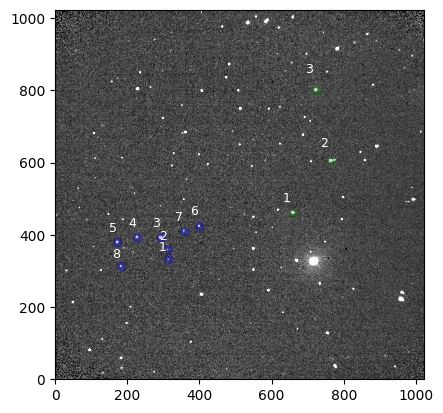

In [370]:
import os
import pandas as pd
from photometry import Photometry
from scripts.tools import sort_files
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import numpy as np
from photometry import Photometry
from copy import copy

star_name = "GRB 230818A"
_set = "first"
camera = 4
src_path = os.path.join(
    "..",
    "Pol charact MOPTOP",
    "Scientific objects",
    star_name,
    f"{_set} set",
    "all data",
)


def read_objects_csv(csv_file, camera):
    df = pd.read_csv(csv_file)
    objects = df.loc[:, ["name", f"ra_cam{camera}", f"dec_cam{camera}"]]
    objects = objects.drop(
        objects[objects["name"] == "star shifts"].index
    ).reset_index()
    objects = objects.drop(["index"], axis=1)
    return objects


csv_file = os.path.join(src_path, "..", "setup", f"objects coordinates.csv")
objects = read_objects_csv(csv_file, camera)

file = os.path.join(src_path, f"{camera}_e_20230818_5_2_1_1.fits")
phot = Photometry(file, objects)
phot.reset_object_coords()

obj = phot.obj_list[0]
xcoord, ycoord = obj.xcoord, obj.ycoord
image = fits.getdata(file)
median = np.median(image)
std = np.median(np.abs(image - median))
plt.imshow(
    image, vmax=median + 8 * std, vmin=median - 3 * std, origin="lower", cmap="gray"
)


for idx, _object in enumerate(phot.obj_list):
    name, x, y = _object.name, _object.xcoord, _object.ycoord
    color = "b"
    if name == "circular":
        color = "r"
    if "comparison" in name:
        color = "g"
    plt.plot(x, y, f"{color}o", alpha=0.25)
    plt.annotate(
        f"{name[-1]}",
        (x * 0.99, y * 1.05),
        ha="right",
        va="bottom",
        fontsize=9,
        color="w",
    )


figure = os.path.join(src_path, "..", "plots", f"field_map.png")
plt.savefig(figure)
plt.show()

# Calculate the star radius

In [ ]:
from fits_files import FITS_files_manager
import collections

csv_file = os.path.join(src_path, "..", "setup", f"objects coordinates.csv")  # TODO
objects = read_objects_csv(csv_file, camera)

star_radius = {"run_num": [], "star_radius": []}
ffiles = FITS_files_manager(src_path)
run_numbers = [obj.run_num for obj in ffiles.cam_files[f"cam{camera}"]]
run_numbers = [item for item, _ in collections.Counter(run_numbers).items()]
for run in run_numbers:
    tmp = []
    run_files = ffiles.get_images_by_run(run)
    for file in run_files[f"cam{camera}"]:
        file = os.path.join(src_path, file.name)
        phot = Photometry(file, objects)
        phot.reset_object_coords()
        tmp.append(phot.calculate_star_radius(coeff_radius_fwhm=2))
    median = np.median(tmp)
    star_radius["star_radius"].append(median)
    star_radius["run_num"].append(run)


dest_files_path = os.path.join(src_path, "..", "polarimetry")
df = pd.DataFrame.from_dict(star_radius)
csv_file = os.path.join(dest_files_path, f"star_radius_cam{camera}.csv")
df.to_csv(csv_file, index=False)

# Create photometry.csv

In [ ]:
csv_file = os.path.join(src_path, "..", "setup", f"objects coordinates.csv")
objects = read_objects_csv(csv_file, camera)
objects = objects.loc[objects["name"] == "candidate1"]


objects_photometry = {}
for obj_name in objects["name"]:
    objects_photometry[obj_name] = {
        "mjd": [],
        "xcoord": [],
        "ycoord": [],
        "star_radius": [],
        "star_photons": [],
        "star_error": [],
    }

csv_file = os.path.join(dest_files_path, f"star_radius_cam{camera}.csv")
df = pd.read_csv(csv_file)
row = df.loc[df["run_num"] == 2]
star_radius = row["star_radius"].iloc[0]
image_list = sort_files(src_path, f"{camera}_e")


for file in image_list:
    file_path = os.path.join(src_path, file)
    phot = Photometry(file_path, objects)
    phot.reset_object_coords()
    phot.star_radius = star_radius
    phot.calc_sky_photons()
    phot.calc_star_photons()

    for idx, _object in enumerate(phot.obj_list):
        objects_photometry[_object.name]["mjd"].append(_object.mjd)
        objects_photometry[_object.name]["xcoord"].append(_object.xcoord)
        objects_photometry[_object.name]["ycoord"].append(_object.ycoord)
        objects_photometry[_object.name]["star_radius"].append(phot.star_radius)
        objects_photometry[_object.name]["star_photons"].append(_object.star_photons)
        objects_photometry[_object.name]["star_error"].append(_object.star_err)
        # objects[f"ra_cam{camera}"][idx] = _object.ra
        # objects[f"dec_cam{camera}"][idx] = _object.dec

dest_files_path = os.path.join(src_path, "..", "polarimetry")
for obj_name, obj_info in objects_photometry.items():
    df = pd.DataFrame.from_dict(obj_info)
    csv_file = os.path.join(dest_files_path, f"{obj_name}_cam{camera}.csv")
    df.sort_values(by=["mjd"])
    df.to_csv(csv_file, index=False)

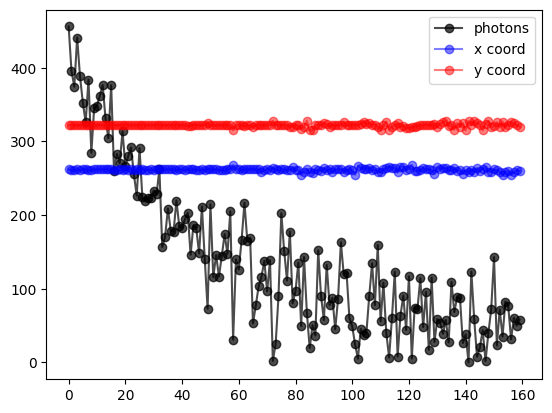

In [399]:
import pandas as pd
import matplotlib.pyplot as plt

target = "candidate1"
dest_files_path = os.path.join(src_path, "..", "polarimetry")  # TODO
file = os.path.join(dest_files_path, f"{target}_cam{3}.csv")
df = pd.read_csv(file)
lim_dix = 16 * 20
df = df[:lim_dix]
x, y, radius, photons, mjd = (
    df["xcoord"],
    df["ycoord"],
    df["star_radius"],
    df["star_photons"],
    df["mjd"],
)
# x /= np.median(x)
# y /= np.median(y)
# radius /= np.median(radius)
# photons /= np.median(photons)
mjd = (mjd - mjd[0]) * 24 * 60
plt.plot(photons, "k-o", alpha=0.7, label="photons")
plt.plot(x, "b-o", alpha=0.5, label="x coord")
plt.plot(y, "r-o", alpha=0.5, label="y coord")
# plt.plot(radius, "g-o", alpha=0.7, label="radius")
plt.legend()
plt.show()

# Looking at the comparison star

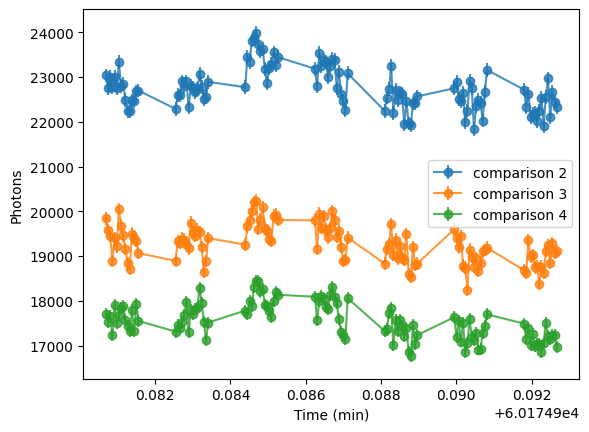

In [337]:
import pandas as pd
import matplotlib.pyplot as plt


def combine_cameras_flux(idx):
    df_cam3 = pd.read_csv(os.path.join(dest_files_path, f"comparison{idx}_cam3.csv"))
    df_cam4 = pd.read_csv(os.path.join(dest_files_path, f"comparison{idx}_cam4.csv"))
    df_cam3 = df_cam3[:lim_dix]
    df_cam4 = df_cam4[:lim_dix]
    mjd = df_cam3["mjd"]
    comp = df_cam3["star_photons"] + df_cam4["star_photons"]
    comp_err = np.sqrt(df_cam3["star_error"] ** 2 + df_cam4["star_error"] ** 2)
    return mjd, comp, comp_err


for idx in range(1, 4):
    mjd, comp, comp_err = combine_cameras_flux(idx)
    plt.errorbar(mjd, comp, comp_err, fmt="o-", alpha=0.8, label=f"comparison {idx+1}")
plt.legend()
plt.xlabel("Time (min)")
plt.ylabel("Photons")
plt.show()

# Creating the final comparison

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def read_comp_csv_files(_list):
    comp, comp_err = [], []
    for idx in _list:
        mjd, tmp, tmp_err = combine_cameras_flux(idx)
        comp.append(tmp)
        comp_err.append(tmp_err)

    comp = np.sum(comp, axis=0)
    comp_err = np.sqrt(np.sum(np.square(comp_err), axis=0))
    mjd_start = mjd[0]
    mjd = (mjd - mjd[0]) * 24 * 60

    return mjd, comp, comp_err, mjd_start


comparisons_list = [1]
mjd, comp, comp_err, _ = read_comp_csv_files(comparisons_list)
median = np.median(comp)
comp /= median
comp_err /= median
std = np.std(comp)
plt.errorbar(mjd, comp, comp_err, fmt="bo-", alpha=0.5)
plt.title(f"std: {std:.2e}")
plt.xlabel("Time (min)")
plt.show()

# Plot light curve

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import scipy
from math import sqrt, log10
from astropy.time import Time


def monoExp(x, a, b, c):
    return a * np.exp(-b * x) + c


def calc_obj_magnitude(star_photons, star_err, comp_photons, comp_err, mag_comparison):
    star_photons, comp_photons = np.asarray(star_photons), np.asarray(comp_photons)

    tmp = star_photons / comp_photons
    tmp_err = np.abs(tmp) * np.sqrt(
        (star_err / star_photons) ** 2 + (comp_err / comp_photons) ** 2
    )
    star_mag = -2.5 * np.log10(tmp) + mag_comparison
    star_mag_err = 2.5 * tmp_err / (tmp * np.log2(10))
    return star_mag, star_mag_err


def calc_exponential_adjust(x, y):
    params, _ = scipy.optimize.curve_fit(monoExp, x, y)
    a, b, c = params
    exp_adjust = monoExp(x, a, b, c)
    return exp_adjust, a, b, c


def calc_linear_adjust(x, y):
    a, b = np.polyfit(x, y, 1)
    return a * x + b, a, b


def plot_light_curve(ax, mjd, cand, cand_err, adjust, adjus_param, n_std=1):
    a, b = adjus_param
    mean = np.mean(cand)
    std = np.std(cand)
    ax.errorbar(
        mjd, cand, cand_err, marker="o", color="b", alpha=0.4, label="data", ls="none"
    )

    ax.plot(mjd, adjust, "b-", label="exponential adjustment")
    ax.set_title(f"f(x) = {a:.2f} * x +{b:.2f}")
    ax.legend(loc="lower left")
    ax.set_ylim(mean - n_std * std, mean + 2 * n_std * std)
    ax.invert_yaxis()


def plot_residuals(ax, cand, cand_err, adjust, n_std=3):
    residuals = cand - adjust
    mean = np.mean(residuals)
    std = np.std(residuals)

    ax.errorbar(
        mjd,
        residuals,
        cand_err,
        marker="o",
        color="b",
        alpha=0.4,
        label="data",
        ls="none",
    )
    ax.set_ylabel("Residuals")
    ax.axhline(mean, color="r", linestyle="--", alpha=0.75)
    ax.set_ylim(mean - n_std * std, mean + n_std * std)
    ax.set_xlabel("Time (min)")
    ax.invert_yaxis()
    ax.annotate(
        f"mean of the residuals: {mean:.2e}\nresiduals std: {std:.2f}\nmean photometry error: {np.mean(cand_err):.2f}",
        (0.05, 0.95),
        fontsize=10,
        ha="left",
        va="top",
        xycoords="axes fraction",
    )


def plot_circular_data(mjd_start: float, ax):
    circulars = ["34487", "34483"]
    for idx, circular in enumerate(circulars):
        csv_path = os.path.join(src_path, "..", "Circulars", circular + ".csv")
        df = pd.read_csv(csv_path)
        utc = df["UT start"].values
        n = 4

        mjd = [Time(value, format="isot").to_value("mjd") for value in utc] - mjd_start
        mjd *= 24 * 60
        mag = df["Rmag"]
        err = df["err"]

        ax.errorbar(
            mjd[:n],
            mag[:n],
            err[:n],
            marker="o",
            color=["r", "g"][idx],
            label="Circular " + circular,
            alpha=0.5,
            ls="none",
        )


def read_star_csv_files(candidate):
    df_cam3 = pd.read_csv(
        os.path.join(dest_files_path, f"candidate{candidate}_cam3.csv")
    )
    df_cam4 = pd.read_csv(
        os.path.join(dest_files_path, f"candidate{candidate}_cam4.csv")
    )
    df_cam3 = df_cam4[:lim_dix]
    df_cam4 = df_cam4[:lim_dix]

    cand = df_cam3["star_photons"] + df_cam4["star_photons"]
    cand_err = np.sqrt(df_cam3["star_error"] ** 2 + df_cam4["star_error"] ** 2)

    mjd = df_cam3["mjd"]
    mjd = (mjd - mjd[0]) * 24 * 60

    return mjd, cand, cand_err


fig, axs = plt.subplots(2, 1, figsize=(6, 5), sharex="col", sharey="row")
mjd, star, star_err = read_star_csv_files(candidate=1)
mjd, comp, comp_err, mjd_start = read_comp_csv_files(comparisons_list)

# norm_star = star / comp
# norm_err = np.abs(norm_star) * np.sqrt((star_err / star) ** 2 + (comp_err / comp) ** 2)
# mean = np.mean(norm_star)
# norm_star /= mean
# norm_err /= mean
comp_magR = 14.543
norm_star, norm_err = calc_obj_magnitude(star, star_err, comp, comp_err, comp_magR)
linear_adjust, *adjus_param = calc_linear_adjust(mjd, norm_star)

# plot_circular_data(mjd_start, axs[0])
plot_light_curve(axs[0], mjd, norm_star, norm_err, linear_adjust, adjus_param, 5)

plot_residuals(axs[1], norm_star, norm_err, linear_adjust, 3)


plt.savefig(os.path.join(src_path, "..", "plots", "light_curve.png"))
plt.show()

# Plot mag for all candidates

In [ ]:
mjd, comp, comp_err, mjd_start = read_comp_csv_files(comparisons_list)


comp_magR = 14.543
fig, ax = plt.subplots(1, 1, figsize=(6, 5), sharex="col", sharey="row")
n_std = 3
for idx in range(8):
    mjd, star, star_err = read_star_csv_files(candidate=idx + 1)
    star, star_err = calc_obj_magnitude(star, star_err, comp, comp_err, comp_magR)
    mean, std = np.mean(star), np.std(star)

    ax.errorbar(
        mjd,
        star,
        star_err,
        marker="o",
        alpha=0.75,
        ls="none",
        label=f"cand{idx+1}",
    )

plt.xlabel("Time (min)")
plt.ylabel("mag R")
plt.ylim(14, 25)
ax.invert_yaxis()

plt.legend(loc="lower right")
plt.savefig(os.path.join(src_path, "..", "plots", "all light curves.png"))
plt.show()

# Calculating the polarization

-0.003975746114645776 0.02857722031682938 -0.0504856679636642 0.028273715933311083
-0.010307143734608415 0.03625188893683176 -0.02250086054381925 0.03526972896237925
0.049883777056637324 0.03957371741035541 -0.016296074895976412 0.04216177275795538
-0.047914948004209375 0.08561917413846121 0.02333753450152611 0.08690088468147035


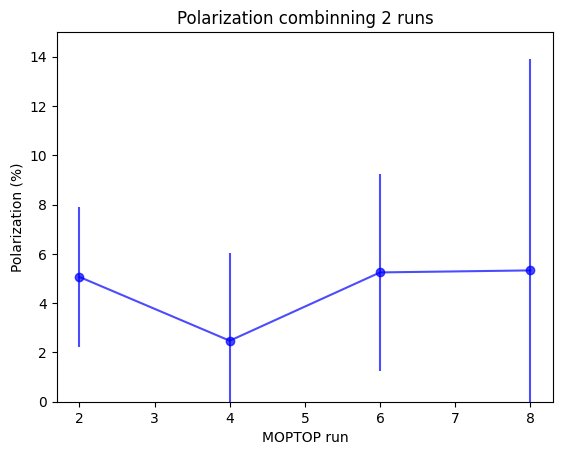

In [401]:
from astropop.polarimetry.dualbeam import SLSDualBeamPolarimetry, halfwave_model
from astropy import units
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt, atan
import os

angles = np.linspace(0, 360 - 22.5, 16)
p = []
p_err = []
csv_path = os.path.join(dest_files_path, "candidate1_cam3.csv")
ss_cam3 = pd.read_csv(csv_path)[:lim_dix]
csv_path = os.path.join(dest_files_path, "candidate1_cam4.csv")
ss_cam4 = pd.read_csv(csv_path)[:lim_dix]

for idx in range(4):
    ss = ss_cam3[idx * 16 : (idx + 1) * 16]
    ord = ss["star_photons"].values
    ord_err = ss["star_error"].values
    ss = ss_cam4[idx * 16 : (idx + 1) * 16]
    extra = ss["star_photons"].values
    extra_err = ss["star_error"].values
    pol_frac = (ord - extra) / (ord + extra)

    pol = SLSDualBeamPolarimetry("halfwave", compute_k=True, zero=0)
    line = np.arange(0, 360, 1) * units.degree

    resul = pol.compute(angles, ord, extra, ord_err, extra_err)
    model = halfwave_model(line, resul.q.nominal, resul.u.nominal, resul.zero)
    noise = halfwave_model(angles, resul.q.nominal, resul.u.nominal, zero=None)
    sigma = noise - resul.zi.nominal

    q, u = float(resul.q), float(resul.u)
    q_err, u_err = float(resul.q.std_dev), float(resul.u.std_dev)
    calculated_pol = np.sqrt(q**2 + u**2)
    calculated_err = np.sqrt(
        (q / calculated_pol) ** 2 * q_err**2 + (u / calculated_pol) ** 2 * u_err**2
    )
    p.append(calculated_pol * 100)
    p_err.append(calculated_err * 100)

plt.errorbar(range(2, len(p) + 6, 2), p, p_err, fmt="bo-", alpha=0.7)
plt.xlabel("MOPTOP run")
plt.ylabel("Polarization (%)")
plt.ylim(0, 15)
plt.title("Polarization combinning 2 runs")
file_path = os.path.join(src_path, "..", "plots", "pol_comb_runs.png")
plt.savefig(file_path, dpi=300)
plt.show()

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0)
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex=ax1)

ax1.set_title(f"q:{q:.3f},  u:{u:.3f}, p:{p:.2f} %, theta:{theta:.1f}")
ax1.plot(line, model, "-b", alpha=0.8, label="astropop")
ax1.errorbar(
    angles,
    resul.zi.nominal,
    yerr=resul.zi.std_dev,
    fmt="ko",
    ms=2,
    capsize=2,
    lw=0.5,
    alpha=0.9,
    label="data",
)
ax1.set_ylabel("Amplitude of modulation")
ax1.legend()

ax2.plot(angles, sigma, "ko", alpha=0.9, label="noise")
ax2.hlines(0, angles[0], angles[-1], linestyles="--", color="b", lw=0.5)
ax2.hlines(-np.mean(sigma), angles[0], angles[-1], linestyles="--", color="b")
ax2.hlines(np.mean(sigma), angles[0], angles[-1], linestyles="--", color="b")
ax2.set_xlabel("Waveplate angle (degrees)")
ax2.set_ylabel("Residuals")